In [1]:
# Last amended: 24th June, 2020
# My folder: D:\data\OneDrive\Documents\credit_card_fraud\credit_card_clustering
# Data source (Kaggle): https://www.kaggle.com/arjunbhasin2013/ccdata
# Ref: Page 248, Aurelien Geron's Book on Machine Learning
# Also see: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py
# Objectives:
#           i)  Apply Gaussian Mixture Clustring techniques in Credit Card Clustering problem
#          ii)  Anomaly detection
#          iii) TSNE and plotting
#

In [2]:

# 1.0 Call libraries
%reset -f
import pandas as pd
import numpy as np

# 1.3 Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 1.4 TSNE
from sklearn.manifold import TSNE

# 1.5 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# 1.6 Import GaussianMixture class
from sklearn.mixture import GaussianMixture

# 1.7 Misc
import os

In [4]:
# IPython Notebook cell multiple outputs
# https://stackoverflow.com/a/42476224/3282777
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# 2.1 Read data and explore
os.chdir("/home/ashok/Documents/credit_card_clustering/")
cc = pd.read_csv("cc_general.csv")

# 2.2 Look at data
cc.head()

# 2.3 Lowercase column names
cc.columns = [i.lower() for i in cc.columns]

# 2.4 examine again
cc.head(2)
cc.shape    # (8950, 18)
cc.dtypes

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


(8950, 18)

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

In [7]:
# 2.4 Are custid unique or do they repeat?
#     Yes, they are
cc['cust_id'].value_counts().shape   # 8950: As many as dataset rows
cc['cust_id'].nunique()              # 8950

# 2.5 Drop Custid columns
cc.drop(columns = ['cust_id'], inplace = True)

(8950,)

8950

balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

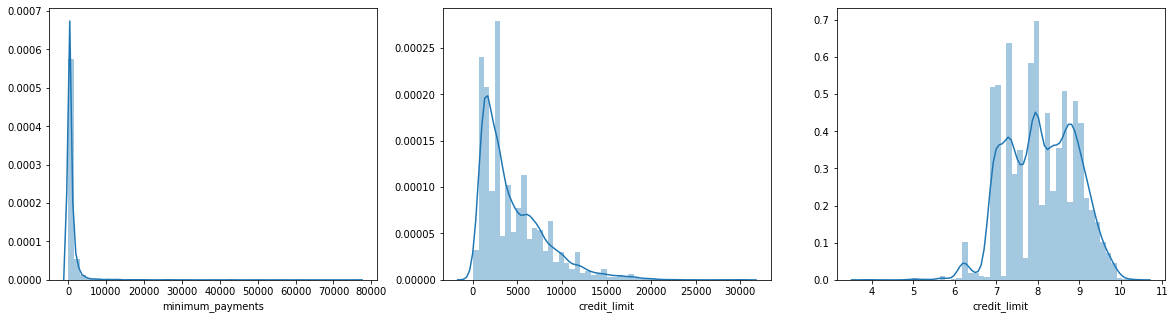

In [16]:
# 2.4 Examine NaNs
cc.isnull().sum()

# 3.0 How to fill NaNs
#  Let us look at distributio graph of minimum_payments
#  and credit_limit
#  Graphs are highly-skewed/skewed to right.
#  So we can not take average as fill-value.
#  Median should be OK.
#  (Another way to fill up is this:
#  cut balance in three or four parts.
#  group data by balance_cut
#  for each group determine median of
#  minimum_payments. Fill up NaN values
#  of median in that group by respective
#  group medians. You may have to use
#  apply() function of groupby)
fig,ax = plt.subplots(1, 3, figsize = (20,5))
abc = sns.distplot(cc.minimum_payments, ax = ax[0]) # skewed to right
abc = sns.distplot(cc.credit_limit,ax = ax[1])     # skewed to right
abc = sns.distplot(np.log(cc.credit_limit),ax = ax[2])  # Almost symmetrical

In [17]:
# 3.1 Create a dictionary of values
#     to be filled up:

values = {
           'minimum_payments' : cc['minimum_payments'].median(),
           'credit_limit' :     cc['credit_limit'].median()
         }

cc.fillna(value = values,inplace = True)
cc.isnull().sum().sum()
cc.shape   # (8950, 17)

0

(8950, 17)

In [18]:
# 4.0 Scale data. feature-wise
ss = StandardScaler()
out = ss.fit_transform(cc)

# 4.1 Normalize data, row-wise or observation wise
#     This may be a good decison
out = normalize(out)
type(out)    # numpy nd array

# 4.2 Transform normalized data to a DataFrame
#     Bring back column names
df_out = pd.DataFrame(out, columns = cc.columns.values)
df_out.shape    # (8950, 17)

numpy.ndarray

(8950, 17)

In [19]:
##########################################
#     Gaussian Mixture Modeling         ##
##########################################

# 5.0 Perform clustering: 3 clusters
#     Instantiate Gaussian Mixture class
gm = GaussianMixture(
                     n_components = 3,
                     n_init = 10,
                     max_iter = 100)

# 5.1 Train the algorithm
gm.fit(out)

# 5.2 Where are the clsuter centers
gm.means_

# 5.3 Did algorithm converge?
gm.converged_   # True

# 5.4 How many iterations did it perform?
gm.n_iter_    # 29

# 5.5 Clusters labels?
gm.predict(out)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

array([[-0.14171865, -0.02264087,  0.00149107, -0.00515395,  0.01288451,
        -0.16272653,  0.12554369,  0.03315423,  0.10326412, -0.23543376,
        -0.16596394,  0.01841606, -0.02927902, -0.07284744, -0.07492416,
         0.05687552,  0.12573816],
       [ 0.04581008,  0.02451937, -0.15450875, -0.11662554, -0.15109751,
         0.08552545, -0.39484341, -0.21043731, -0.30479979,  0.16106066,
         0.08037776, -0.19461903, -0.08497592, -0.05146006, -0.03249554,
        -0.14155324, -0.00453998],
       [ 0.03935356,  0.07641853, -0.01317142, -0.01104582, -0.01063305,
         0.02643366,  0.07236976,  0.02295896,  0.04073361,  0.08609872,
         0.04459128, -0.00493462, -0.04678536, -0.01372598,  0.03859707,
        -0.07293025, -0.06328744]])

True

43

array([0, 1, 0, ..., 2, 1, 2])

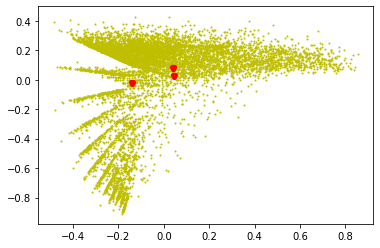

In [21]:

# 6.0 Plot cluster and cluster centers
#     Data has many columns.
#     Which column to select to plot in 2D?
#     We should select impt columns
#     But following selection is arbitrary

fig = plt.figure()
abc = plt.scatter(out[:, 0], out[:, 1], c='y', s=1)
abc = plt.scatter(gm.means_[:, 0], gm.means_[:, 1],
                  marker='v',
                  s=5,               # marker size
                  linewidths=5,      # linewidth of marker edges
                  color='red'
                  )

plt.show()

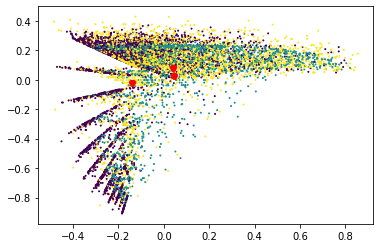

In [23]:
# 5.1 Let us also colour the points cluster-wise
#     Not much help.

fig = plt.figure()
abc = plt.scatter(out[:, 0], out[:, 1], c=gm.predict(out), s=1)
abc = plt.scatter(gm.means_[:, 0], gm.means_[:, 1],
                  marker='v',
                  s=5,               # marker size
                  linewidths=5,      # linewidth of marker edges
                  c='red'
                 )
plt.show()

In [25]:
# 6.0 Anomaly detection
#     Anomalous points are those that
#     are in low-density region
#     Or where density is in low-percentile
#     of, say 4%
#     score_samples() method gives score or
#     density of a point at any location.
#     Higher the value, higher its density

densities = gm.score_samples(out)
densities[:4]
# 6.1 Get 4% density threshold
density_threshold = np.percentile(densities,4)
density_threshold       # 4.811157476790031

# 6.2 Get anomalies ie points with less density environment
anomalies = out[densities < density_threshold]
anomalies[:2]
anomalies.shape    # (358, 17)

# 6.3 Unanomalous data
unanomalous = out[densities >= density_threshold]
unanomalous[:2]
unanomalous.shape   # (8592, 17)

array([31.95886236, 33.01889301, 26.22677571,  3.81817899])

4.811181205399739

array([[ 0.02049493, -0.42449573,  0.09686543,  0.22799003, -0.1897489 ,
        -0.15388299, -0.42331555, -0.16668357, -0.3827715 , -0.10807542,
        -0.13755381, -0.2302337 ,  0.34483003, -0.24990404, -0.09529971,
        -0.21937513,  0.15055461],
       [ 0.11237996, -0.07585164, -0.02556323, -0.0427579 ,  0.01804423,
        -0.05591725,  0.15211728, -0.08129825,  0.19157154, -0.0809015 ,
        -0.05702944, -0.00342096,  0.21419435,  0.28976468,  0.87392918,
        -0.06295689,  0.04320658]])

(358, 17)

array([[-0.31209021, -0.10634862, -0.1811598 , -0.15218201, -0.14883288,
        -0.19901819, -0.34385437, -0.2893531 , -0.30156929, -0.28794102,
        -0.20297662, -0.2180115 , -0.40946592, -0.22553484, -0.12893094,
        -0.22407336,  0.15377895],
       [ 0.21991172,  0.03753626, -0.1312136 , -0.09974318, -0.12702874,
         0.72812132, -0.34141332, -0.18964789, -0.25624908,  0.16039061,
         0.03075951, -0.16537398,  0.19244726,  0.22876487,  0.02724569,
         0.06545337,  0.10078984]])

(8592, 17)

In [26]:
# 6.4 Store anomaly values in a data frame.
#     We assign proper column names also
df_anomaly = pd.DataFrame(anomalies, columns = cc.columns.values)
df_anomaly.shape    # (358, 17)

# 6.5 Same with unanomalous clients
df_unanomaly = pd.DataFrame(unanomalous, columns = cc.columns.values)
df_unanomaly.shape    # (8592, 17)

(358, 17)

(8592, 17)

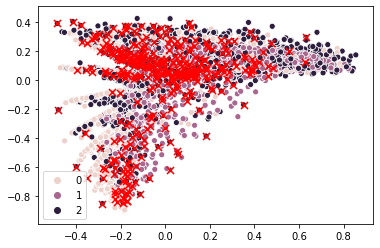

In [28]:
# 6.6 Plot cluster and anomalies
#     All mixed up in 2D. Not much help
fig = plt.figure()
abc = sns.scatterplot(
                x = out[:,0],   # If you change the index, change below also
                y = out[:,1],
                hue = gm.predict(out)
                )

abc = plt.scatter(
            df_anomaly.iloc[:, 0],   # Index same as above
            df_anomaly.iloc[:, 1],   # Index same as in earlier scatterplot
            marker='x',
            s=50,               # marker size
            linewidths=50,      # linewidth of marker edges
            color='red'
            )
plt.show()

In [29]:
# 7.0 How many clusters should there be?
#     Use either AIC or BIC as criterion
#     Ref: https://en.wikipedia.org/wiki/Akaike_information_criterion
#          https://en.wikipedia.org/wiki/Bayesian_information_criterion
#          https://www.quora.com/What-is-an-intuitive-explanation-of-the-Akaike-information-criterion

bic = []
aic = []
for i in range(8):
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(out)
    bic.append(gm.bic(out))
    aic.append(gm.aic(out))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

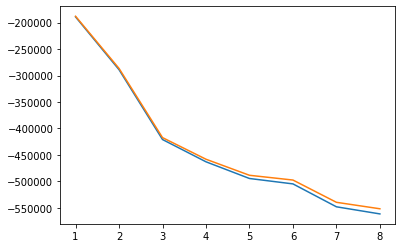

In [31]:
# 7.1 Look at the aic and bic plots
#     Plot has an elbow at 3-clusters

fig = plt.figure()
abc = plt.plot([1,2,3,4,5,6,7,8], aic)
abc = plt.plot([1,2,3,4,5,6,7,8], bic)
plt.show()

In [32]:
# 8.0 (TSNE) t-stochaistic neighbourhood embedding
#     Let us project this data in 2D,
#     also darw a 2-D t-sne plot and colour
#     points by gmm-cluster labels

# 8.1 2-clusters
gm_2 = GaussianMixture(
                     n_components = 2,
                     n_init = 10,
                     max_iter = 100)

# 8.2 Train the algorithm
gm_2.fit(out)

# 8.3  3-clusters
gm_3 = GaussianMixture(
                     n_components = 3,
                     n_init = 10,
                     max_iter = 100)

# 8.4 Train the algorithm
gm_3.fit(out)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [34]:
# 9.0 Plot clusters after TSNE learning
#     Both graphs show the presence of
#     good clusters

# 9.1 First do t-sne
#    (2D projection so that we can plot all data)
tsne = TSNE(n_components = 2)
tsne_out = tsne.fit_transform(out)

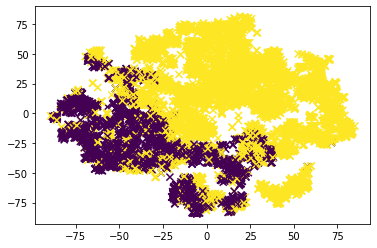

In [36]:
# 9.2 Now plot and colour.
#     Ist Graph with 2-clusters
abc = plt.scatter(tsne_out[:, 0], tsne_out[:, 1],
                  marker='x',
                  s=50,              # marker size
                  linewidths=5,      # linewidth of marker edges
                  c=gm_2.predict(out)   # Colour as per gmm
                 )

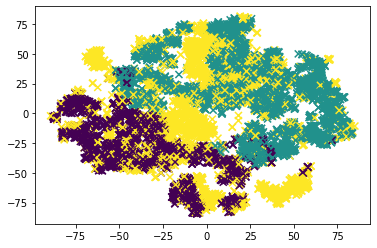

In [37]:
# 9.3 Graph with 3-clusters
abc = plt.scatter(tsne_out[:, 0], tsne_out[:, 1],
                  marker='x',
                  s=50,              # marker size
                  linewidths=5,      # linewidth of marker edges
                  c=gm_3.predict(out)   # Colour as per gmm
                 )

In [38]:
# 10.0 How are anomalous data different from regular data
#      The following functions takes 2-DataFrames as input

def densityplots(df1,df2, label1 = "Anomalous",label2 = "Normal"):
    # 10.1 As number of features are 17, we have 20 axes
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,15))
    ax = axes.flatten()
    fig.tight_layout()
    # 10.2 Do not display 18th, 19th and 20th axes
    axes[3,3].set_axis_off()    # 4th row, 4th frame
    axes[3,2].set_axis_off()    # 4th row, 3rd frame
    axes[3,4].set_axis_off()    # 4th row, 5th frame
    # 10.3 Below 'j' is not used.
    for i,j in enumerate(df1.columns):
        # sns.distplot() code taken from following reference:
        # https://seaborn.pydata.org/generated/seaborn.distplot.html

        # 10.4 For every i, draw two overlapping density plots in different colors
        sns.distplot(df1.iloc[:,i],
                     ax = ax[i],
                     kde_kws={"color": "k", "lw": 3, "label": label1},   # Density plot features
                     hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"}) # Histogram features
        sns.distplot(df2.iloc[:,i],
                     ax = ax[i],
                     kde_kws={"color": "red", "lw": 3, "label": label2},
                     hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "b"})


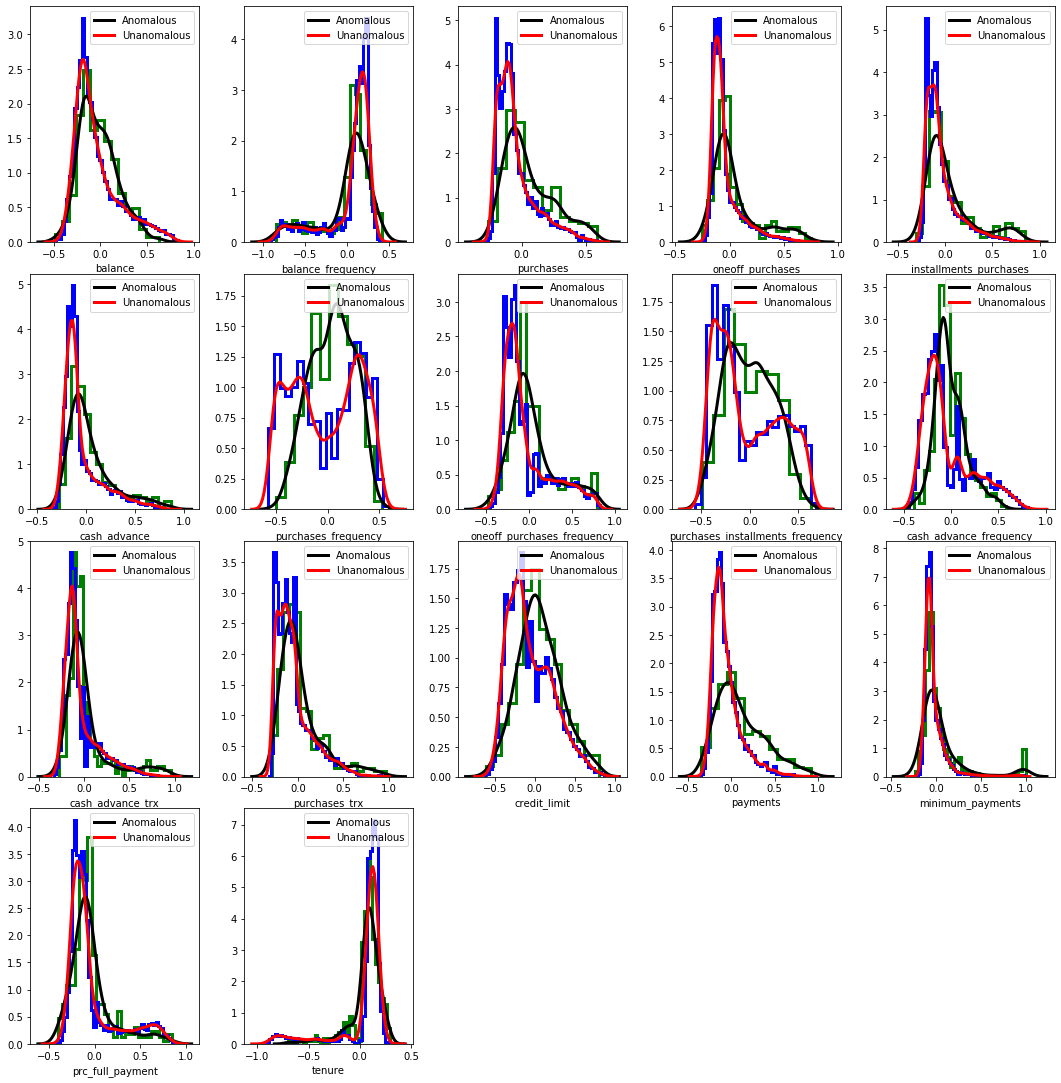

In [39]:
# 11.0 For all 17 features, draw overlapping density plots now
densityplots(df_anomaly,df_unanomaly, label2 = "Unanomalous")

In [ ]:
############# Done ##########################